# Sales Analysis

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import shapiro
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Configurations
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
dataframe = pd.read_csv('../datasets/superstore.csv')
dataframe.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


## 1. Data Manipulation

In [4]:
# Create dataframe for manipulation
dataframe_manipulation = dataframe.copy()

In [5]:
# String to date
dataframe_manipulation[['Order Date', 'Ship Date']] = \
    dataframe_manipulation[['Order Date', 'Ship Date']].apply(pd.to_datetime)

In [6]:
# Order to ship days
dataframe_manipulation['Order to Ship Days'] = (
    dataframe_manipulation['Ship Date'] - dataframe_manipulation['Order Date']
).dt.days

In [7]:
# Create year-month feature
dataframe_manipulation['Order Year-Month'] = \
    dataframe_manipulation["Order Date"].apply(
        lambda x: pd.to_datetime(f'{x.year}-{x.month}')
    )

In [8]:
# group by month
grouby_order_date = dataframe_manipulation.groupby('Order Year-Month')

In [9]:
# Create sales dataframe
dataframe_sales = pd.DataFrame()

In [10]:
# Order year
dataframe_sales['Order Year'] = (
    grouby_order_date['Order Year-Month']
        .unique()
        .apply(pd.DatetimeIndex)
        .apply(lambda x: x[0].year)
)

In [11]:
# Order month
dataframe_sales['Order Month'] = (
    grouby_order_date['Order Year-Month']
        .unique()
        .apply(pd.DatetimeIndex)
        .apply(lambda x: x[0].month)
)

In [12]:
# Number of orders
dataframe_sales['No of Orders'] = grouby_order_date['Order ID'].nunique()

In [13]:
# Number of customers
dataframe_sales['No of Customers'] = grouby_order_date['Customer ID'].nunique()

In [14]:
# Number of cities
dataframe_sales['No of Cities'] = grouby_order_date['City'].nunique()

In [15]:
# Number of products
dataframe_sales['No of Products'] = grouby_order_date['Product ID'].nunique()

In [16]:
# Total sales
dataframe_sales['Total Sales'] = grouby_order_date['Sales'].sum()

In [17]:
# Total profit
dataframe_sales['Total Profit'] = grouby_order_date['Profit'].sum()

In [18]:
# Total costs
dataframe_sales['Total Costs'] = grouby_order_date['Shipping Cost'].sum()

In [19]:
# Total quantity
dataframe_sales['Total Quantity'] = grouby_order_date['Quantity'].sum()

## 2. Visualizations

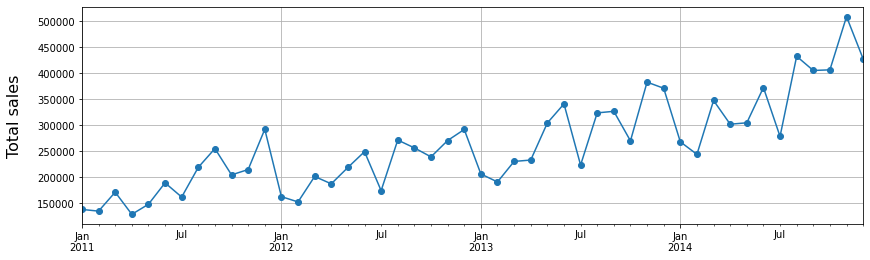

In [20]:
# Total sales
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['Total Sales'].plot(marker='o', ax=ax)
plt.ylabel('Total sales', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

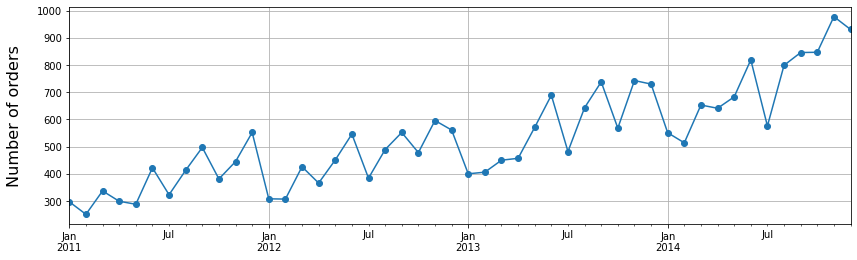

In [21]:
# Number of orders
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['No of Orders'].plot(marker='o', ax=ax)
plt.ylabel('Number of orders', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

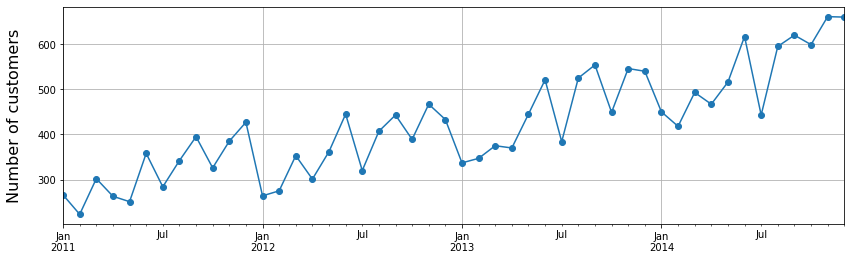

In [22]:
# Number of customers
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['No of Customers'].plot(marker='o', ax=ax)
plt.ylabel('Number of customers', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

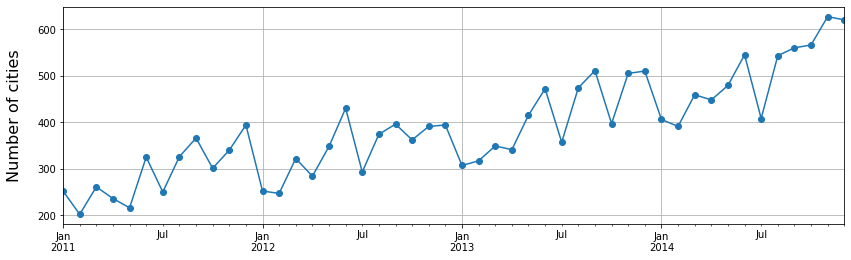

In [23]:
# Number of cities
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['No of Cities'].plot(marker='o', ax=ax)
plt.ylabel('Number of cities', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

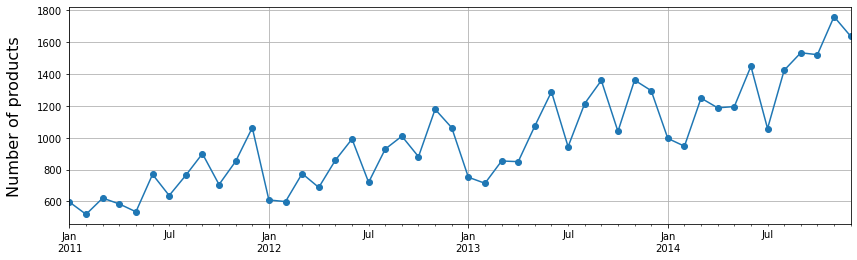

In [24]:
# Number of products
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['No of Products'].plot(marker='o', ax=ax)
plt.ylabel('Number of products', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

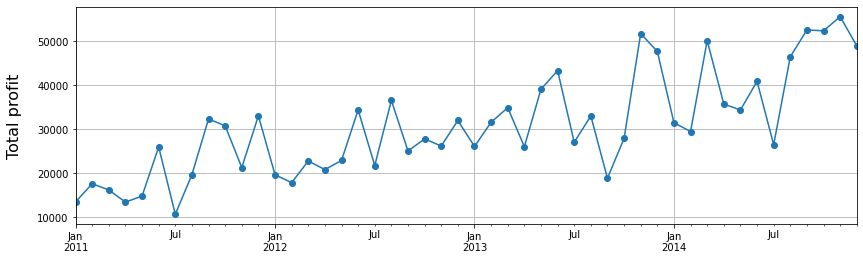

In [25]:
# Total profit
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['Total Profit'].plot(marker='o', ax=ax)
plt.ylabel('Total profit', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

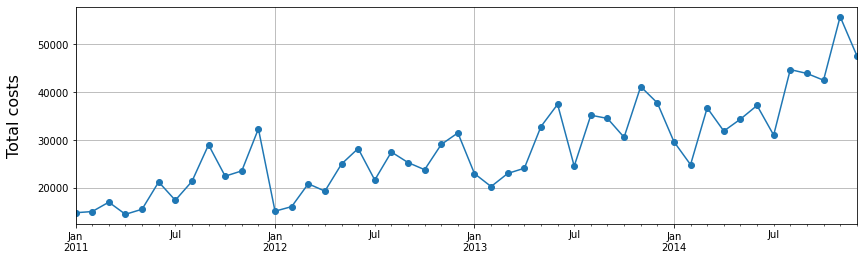

In [26]:
# Total costs
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['Total Costs'].plot(marker='o', ax=ax)
plt.ylabel('Total costs', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

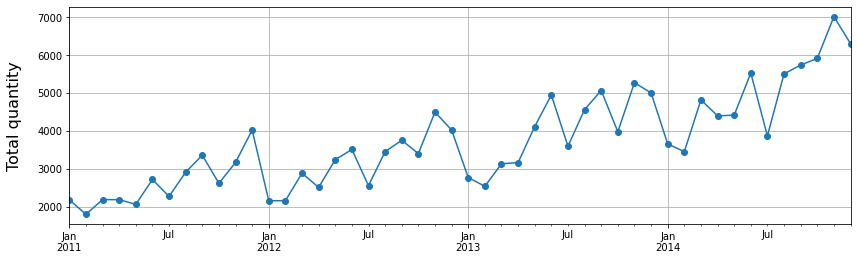

In [27]:
# Total qualtity
fig, ax = plt.subplots(figsize=(14, 4))
dataframe_sales['Total Quantity'].plot(marker='o', ax=ax)
plt.ylabel('Total quantity', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

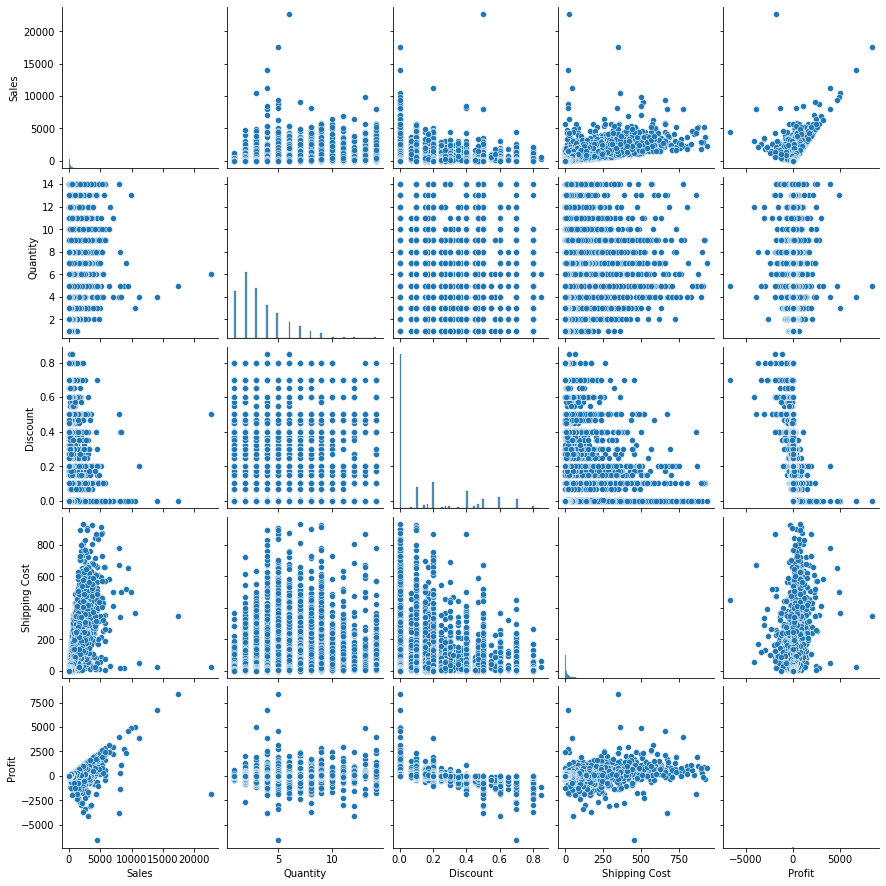

In [28]:
# Pair plot
dataframe_corr = dataframe[
    ['Sales', 'Quantity', 'Discount', 'Shipping Cost', 'Profit']
]
sns.pairplot(dataframe_corr)
plt.show()

## 3. Feature Importance

In [29]:
# Drop irrelevant features
dataframe_importance = dataframe.drop([
    'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID',
    'Customer Name', 'Postal Code', 'Product Name', 'Profit'
], axis=1)

In [30]:
# Encode categorical data
CATEGORICAL_FEATURES = [
    'Ship Mode', 'Segment', 'City', 'State',
    'Country', 'Market', 'Region', 'Product ID',
    'Category', 'Sub-Category', 'Order Priority'
]

dataframe_encoded = dataframe_importance.copy()
for feature in CATEGORICAL_FEATURES:
    dataframe_encoded[feature] = \
        LabelEncoder().fit_transform(dataframe_importance[feature])

dataframe_encoded.head()

,Ship Mode,Segment,City,State,Country,Market,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Shipping Cost,Order Priority
0,3,0,785,255,2,1,0,7846,1,14,408.300,2,0.0,35.46,3
1,3,0,3453,702,6,0,9,7464,1,15,120.366,3,0.1,9.72,3
2,2,0,515,175,56,3,5,7858,1,14,66.120,4,0.0,8.17,1
3,2,2,3071,939,123,4,7,6206,1,12,44.865,3,0.5,4.82,1
4,3,0,3453,702,6,0,9,1492,0,9,113.670,5,0.1,4.70,3


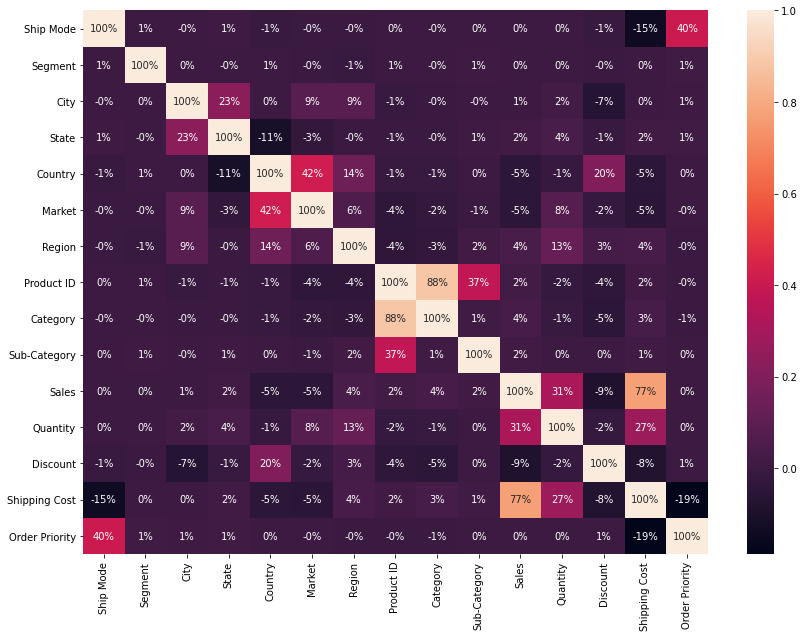

In [31]:
# Pearson's correlation
plt.figure(figsize=(14, 10))
_ = sns.heatmap(dataframe_encoded.corr(), annot=True, fmt=".0%")

In [32]:
# Select features
x = dataframe_encoded.drop('Sales', axis=1)
y = dataframe_encoded['Sales']

In [33]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [34]:
%%time

# Train

search = BayesSearchCV(
    RandomForestRegressor(n_estimators=10, oob_score=True, random_state=1),
    {'min_samples_split': (2, 100), 'min_samples_leaf': (1, 100)},
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=20,
    return_train_score=True,
    random_state=1
)
search.fit(x_train, y_train)

model = search.best_estimator_

CPU times: user 1min 21s, sys: 3.2 s, total: 1min 24s
Wall time: 1min 40s


In [35]:
# Predict
y_hat = model.predict(x_test)

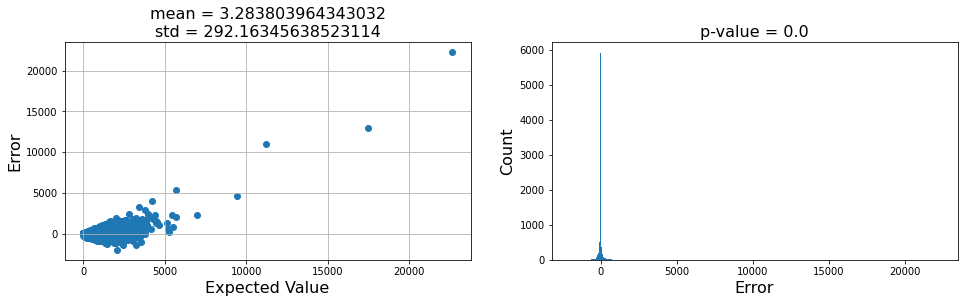

In [36]:
# Evaluate
errors = y_test - y_hat
_, p_value = shapiro(errors)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

ax[0].scatter(y_test, errors)
ax[0].set_xlabel('Expected Value', size=16)
ax[0].set_ylabel('Error', size=16)
ax[0].set_title(
    f'mean = {errors.mean()}\nstd = {errors.std()}', size=16)
ax[0].grid()

ax[1].hist(errors, bins=1000)
ax[1].set_xlabel('Error', size=16)
ax[1].set_ylabel('Count', size=16)
ax[1].set_title(f'p-value = {p_value}', size=16)

plt.show()

In [37]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=x.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance = feature_importance / feature_importance.apply(abs).sum()

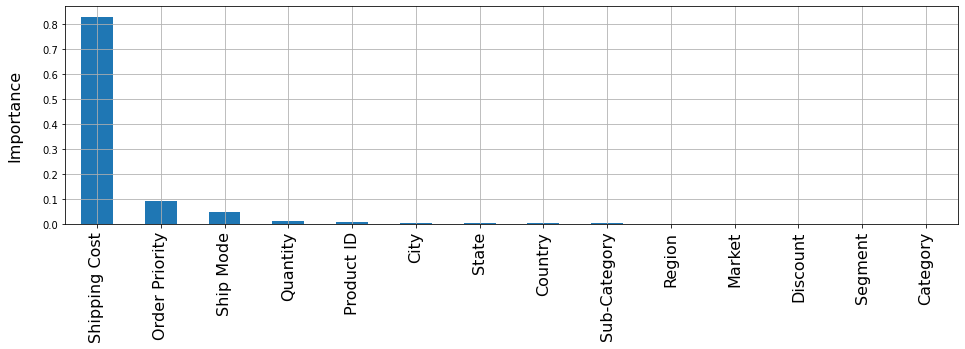

In [38]:
# Visualize importances
fig, ax = plt.subplots(figsize=(16, 4))
feature_importance.plot(kind='bar', label='importance')
plt.ylabel('Importance', size=16, labelpad=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.grid()
plt.show()

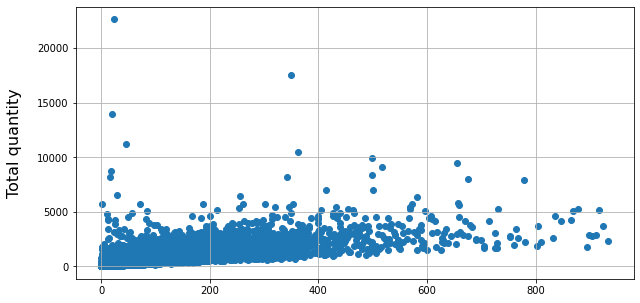

In [39]:
# How shipping cost is related to sales?
plt.figure(figsize=(10, 5))
plt.scatter(dataframe['Shipping Cost'], dataframe['Sales'])
plt.ylabel('Total quantity', size=16, labelpad=15)
plt.xlabel('')
plt.grid()
plt.show()

## 4. Forecasting

In [40]:
# Get forecasting features
dataframe_forecast = dataframe_sales[['Total Sales']]
dataframe_forecast.head()

,Total Sales
Order Year-Month,
2011-01-01,138241.30042
2011-02-01,134969.94086
2011-03-01,171455.59372
2011-04-01,128833.47034
2011-05-01,148146.72092


In [41]:
# Dataset shape
print(f'dataset shape: {dataframe_forecast.shape}')

dataset shape: (48, 1)


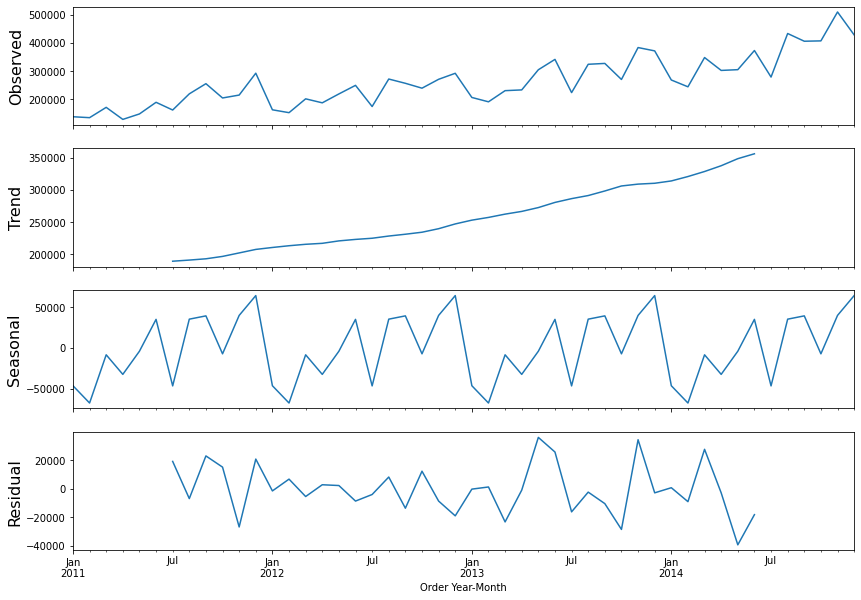

In [42]:
# Decompose series
decomposition = seasonal_decompose(dataframe_forecast, model='additive')

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14, 10))

decomposition.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed', size=16)
decomposition.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend', size=16)
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal', size=16)
decomposition.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual', size=16)

plt.show()

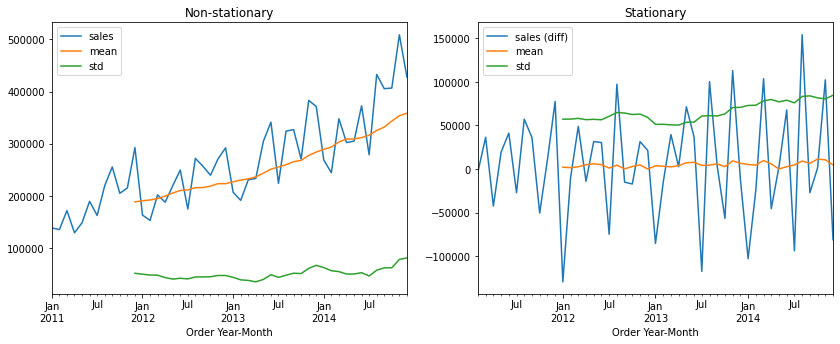

In [43]:
# Stationary
dataframe_stationary = dataframe_forecast.diff(1).iloc[1:]

fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

dataframe_forecast.plot(ax=ax[0])
dataframe_forecast.rolling(12).mean().plot(ax=ax[0])
dataframe_forecast.rolling(12).std().plot(ax=ax[0])
ax[0].set_title('Non-stationary')
ax[0].legend(['sales', 'mean', 'std'])

dataframe_stationary.plot(ax=ax[1])
dataframe_stationary.rolling(12).mean().plot(ax=ax[1])
dataframe_stationary.rolling(12).std().plot(ax=ax[1])
ax[1].set_title('Stationary')
ax[1].legend(['sales (diff)', 'mean', 'std'])

plt.show()

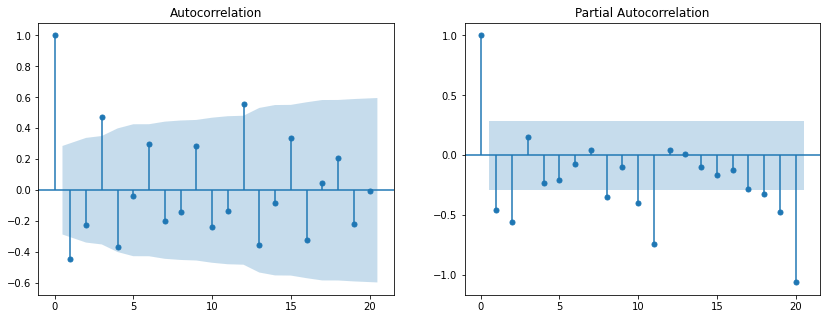

In [44]:
# Autocorrelations
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
plot_acf(dataframe_stationary, lags=20, ax=ax[0])
plot_pacf(dataframe_stationary, lags=20, ax=ax[1])
plt.show()

In [45]:
# Starting point
# based on the negative values at lag 1
# and also in the seasonal plot
model = SARIMAX(
    dataframe_forecast,
    order=(0, 1, 1), 
    seasonal_order=(0, 1, 1, 12)
).fit()

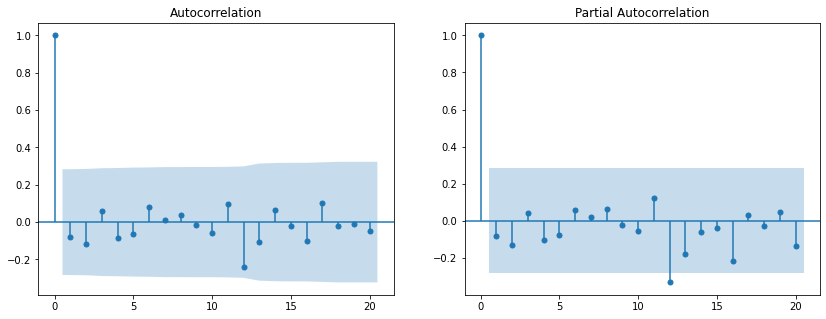

In [46]:
# Evaluating starting point
residual = model.resid
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
plot_acf(residual, lags=20, ax=ax[0])
plot_pacf(residual, lags=20, ax=ax[1])
plt.show()

In [47]:
# Split the dataset
train_size = int(len(dataframe_forecast) * 0.85)
x_train = dataframe_forecast[:train_size]
x_test = dataframe_forecast[train_size:]

In [48]:
# Scoring function

# I have to implement since I'm using sklearn 0.23 because of sklearn-optimization
def mean_absolute_percentage_error(actual, prediction):
    assert len(actual) == len(prediction)
    actual = np.array(actual)
    prediction = np.array(prediction)
    difference = abs(actual - prediction)
    percentage = 100 * (difference / abs(actual))
    mape = percentage.sum() / len(actual)
    return mape

In [49]:
# Evaluation function

def evaluate_arima(x_train, x_test, order):

    predictions = []
    seasonal_order = order + [12]
    for i in range(len(x_test)):

        model = SARIMAX(
            x_train,
            order=order,
            seasonal_order=seasonal_order
        )
        model_fit = model.fit()

        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)
        x_train.append(x_test[i])

    mape = mean_absolute_percentage_error(x_test, predictions)
    return mape, predictions

In [50]:
# Hyperparameter tunning

def tune_arima(x, p_list, d_list, q_list):
    
    train_size = int(len(x) * 0.7)
    x_train = [value for value in x[:train_size]]
    x_validation = [value for value in x[train_size:]]
    
    best_score = float('inf')
    best_order = None
    for p in p_list:
        for d in d_list:
            for q in q_list:
                order = [p, d, q]
                try:
                    mape, _ = evaluate_arima(x_train, x_validation, order)
                except Exception:
                    continue
                if mape < best_score:
                    best_score = mape
                    best_order = order

    print(f'best order: {best_order}')
    return best_order

In [51]:
%%time

# Train model
p_list = [0, 1, 2]
d_list = [1, 2]
q_list = [1, 2]
best_order = tune_arima(x_train.values, p_list, d_list, q_list)

best order: [0, 1, 1]
CPU times: user 5min 38s, sys: 28.8 s, total: 6min 7s
Wall time: 4min


In [52]:
# Evaluate model
x_train_list = [item for item in x_train.values]
x_test_list = [item for item in x_test.values]
_, predictions = evaluate_arima(x_train_list, x_test_list, best_order)
mape = mean_absolute_percentage_error(x_test.values[:, 0], predictions)
print(f'mape: {mape}')

mape: 10.722243219866556


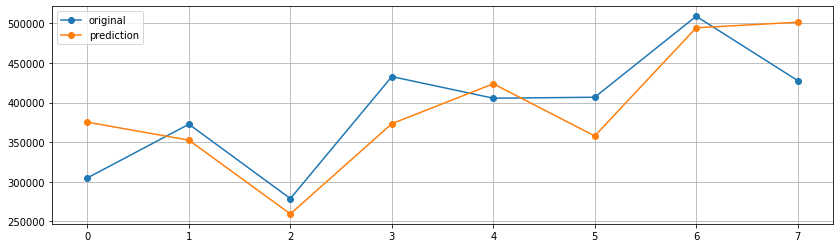

In [53]:
# Visualize errors
plt.figure(figsize=(14, 4))
plt.plot(x_test_list, marker='o', label='original')
plt.plot(predictions, marker='o', label='prediction')
plt.legend(loc='best')
plt.grid()
plt.show()

In [54]:
# Forecast
x = [item for item in dataframe_forecast.values]
model = SARIMAX(x, order=best_order, seasonal_order=best_order+[12])
model_fit = model.fit()
y_forecast = model_fit.forecast()[0]
print(f'2015-01-01: {y_forecast}')

2015-01-01: 342988.6616393066


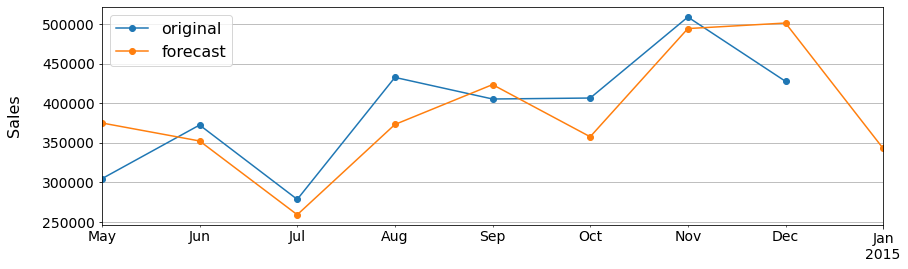

In [55]:
# Visualize forecast
observed = dataframe_forecast['Total Sales'].copy()
forecast = x_test['Total Sales'].copy()
forecast.iloc[:] = predictions
forecast[pd.to_datetime('2015-01-01')] = y_forecast

fig, ax = plt.subplots(figsize=(14, 4))
observed[train_size:].plot(marker='o', label='original')
forecast.plot(marker='o', label='forecast')
plt.legend(loc='best', prop={'size': 16})
plt.ylabel('Sales', size=16, labelpad=20)
plt.xlabel('')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(14)
plt.grid()
plt.show()

## Conclusions

In this notebook, we first created the features that we are interested in. Then we took a look at how each one of them evolved over the years and how they correlate with each other.

Next, we tried to understand what features are the most relevant to sales. For that, a random forest regressor was trained and the feature importance was extracted from it. By far, the shipping cost is the most important feature, followed by the order priority.

Finally, we used a SARIMAX model to forecast the next month sales to handle the trend and seasonality of our time series. It achieved a mean error of 10%.